# ETL's and Exploratory Data Analysis 

## Setup and ETL's

In this section we will setup our environment and also will get  all the data needed to make our EDA, this include internal and external databases. Also, we will create some synthetic features that we think could be usefull to better understand the patterns associated with flight delays

### Setup environment

#### Import libraries

In [156]:
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import pandas as pd
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
import numpy as np
import statsmodels as sm
import scipy.stats
from scipy.stats import beta,norm, gamma,chi2
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="iair_linker_cornershop_challenge")
from geopy.distance import geodesic
# Preprocessing libraries
# Using make_column_transformer to One-Hot Encode
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from prince import mca
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBClassifier

#### Set environment

In [2]:
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
os.chdir(directory_path)
os.getcwd()

'/Users/iairlinker/Documents/repos/flight_delays_challenge'

### Home made functions definition

In [3]:
def get_hist(var1,var2,name_image,values_range=[0,1],nbins=20,normed=True):
    
    common_params = dict(bins=nbins,range=values_range,normed=normed)
    plt.subplots_adjust(hspace=.8)
    plt.subplot(311)
    plt.title('Default')
    #plt.hist(df.popularity, **common_params)
    plt.hist(var1, **common_params)
    plt.hist(var2, **common_params)
    plt.subplot(312)
    plt.title('Skinny shift - 2 at a time')
    plt.hist((var1, var2), **common_params)
    plt.subplot(313)
    common_params['histtype'] = 'step'
    plt.title('With steps')
    #plt.hist(df.popularity, **common_params)
    plt.hist(var1, **common_params)
    plt.hist(var2, **common_params)

    plt.savefig(name_image)
    plt.show()
    
def create_delays(x):
    if(x<=15):
        return 'a tiempo'
    elif((x>15)&(x<=45)):
        return 'retraso leve'
    elif((x>45)&(x<=90)):
        return 'retraso crítico'
    elif((x>90)&(x<=180)):
        return 'retraso crítico'
    elif(x>180):
        return 'retraso grave'
    
def create_variables(data):
    # create the variable of number of flights in origin by date operated and merge it with the database
    aux = data.groupby(['fecha_operacion'])['Ori-O'].count().reset_index().sort_values(by='Ori-O')
    aux.rename(columns={'Ori-O':'NVuelos-Ori-O'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion'], how='left')

    # create the variable of number of flights in origin by date scheduled and merge it with the database
    aux = data.groupby(['fecha_operacion'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
    aux.rename(columns={'Ori-I':'NVuelos-Ori-I'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion'], how='left')

    # create the variable of number of flights in destiny scheduled by date and airline scheduled
    aux = data.groupby(['fecha_operacion','Emp-I'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
    aux.rename(columns={'Ori-I':'Nvuelos-Fecha-Emp-I'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion','Emp-I'], how='left')

    # create the variable of number of flights in by date and airline who operated it
    aux = data.groupby(['fecha_operacion','Emp-O'])['Ori-O'].count().reset_index().sort_values(by='Ori-O')
    aux.rename(columns={'Ori-O':'Nvuelos-Fecha-Emp-O'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion','Emp-O'], how='left')

    # create the variable of number of flights in operated destiny by date of operation and airline who operated it
    aux = data.groupby(['fecha_operacion','Emp-O','Des-O'])['Ori-O'].count().reset_index().sort_values(by='Ori-O')
    aux.rename(columns={'Ori-O':'Nvuelos-Fecha-Emp-Des-O'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion','Emp-O','Des-O'], how='left')

    # create the variable of number of flights in destiny scheduled by date scheduled and airline scheduled
    aux = data.groupby(['fecha_operacion','Emp-I','Des-I'])['Ori-I'].count().reset_index().sort_values(by='Ori-I')
    aux.rename(columns={'Ori-I':'Nvuelos-Fecha-Emp-Des-I'}, inplace=True)
    data = pd.merge(data, aux, on = ['fecha_operacion','Emp-I','Des-I'], how='left')

    # Change in the code of the flight
    data[['Vlo-I_cambio']] = 0
    data.loc[data[data['Vlo-I'] != data['Vlo-O']].index,'Vlo-I_cambio'] = 1
    
    return data

def scale_data(x,y,scale):
    if(scale=='min-max'):
        scaler = MinMaxScaler()
        scaler .fit(x,y)
        return scaler 
    elif( scale == 'robustscaler'):
        scaler = RobustScaler()
        scaler .fit(x,y)
        return scaler 
    elif(scale=='normalize'):
        scaler = Normalizer()
        scaler .fit(x,y)
        return scaler 
    else:
        raise Exception('You did not introduce a valid parameter for scale')
    
# Get the count and % of NA's
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

def get_hist(x,var):
    print(x[var].describe())
    sns.histplot(data=x, x=var, kde=True, bins=50)
    plt.title('Histogram of ' + var)
    plt.show();
    
    
def get_cdf_pdf(x):
    # getting data of the histogram
    count, bins_count = np.histogram(x, bins=10)
    # finding the PDF of the histogram using count values
    pdf = count / sum(count)
    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)
    # plotting PDF and CDF
    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.plot(bins_count[1:], cdf, label="CDF")
    plt.legend()
    
def get_boxplot_target_by_var(x,var,target):
    print(x.groupby(var)[target].describe())
    sns.boxplot(x=var, y=target,data=x)
    plt.title("Boxplot of " + target + " by " + var);
    
def scatterplot_target_by_var(x,var1, var2,target):
    sns.scatterplot(data=x, y=target, x=var1, hue=var2 , legend=False)
    plt.title("Scatterplot of found"+ target + " and " + var1 + "respect to " + var2)
    plt.show();

In [312]:
# Loading the joined dataset between flights and Airport database
path = os.getcwd() + '/data/processed/database.csv'
df = pd.read_csv(path, sep=',')
df = create_variables(data = df)
df['tipo_atraso'] = df.dif_min.apply(lambda x: create_delays(x))
print(df.shape)
df.head()

(68206, 39)


Fecha-I Vlo-I Ori-I Des-I Emp-I              Fecha-O Vlo-O  \
0  2017-01-01 23:30:00   226  SCEL  KMIA   AAL  2017-01-01 23:33:00   226   
1  2017-01-02 23:30:00   226  SCEL  KMIA   AAL  2017-01-02 23:39:00   226   
2  2017-01-03 23:30:00   226  SCEL  KMIA   AAL  2017-01-03 23:39:00   226   
3  2017-01-04 23:30:00   226  SCEL  KMIA   AAL  2017-01-04 23:33:00   226   
4  2017-01-05 23:30:00   226  SCEL  KMIA   AAL  2017-01-05 23:28:00   226   

  Ori-O Des-O Emp-O  DIA  MES   AÑO     DIANOM TIPOVUELO              OPERA  \
0  SCEL  KMIA   AAL    1    1  2017    Domingo         I  American Airlines   
1  SCEL  KMIA   AAL    2    1  2017      Lunes         I  American Airlines   
2  SCEL  KMIA   AAL    3    1  2017     Martes         I  American Airlines   
3  SCEL  KMIA   AAL    4    1  2017  Miercoles         I  American Airlines   
4  SCEL  KMIA   AAL    5    1  2017     Jueves         I  American Airlines   

   SIGLAORI SIGLADES  dif_min  atraso_15 tipo_atraso periodo_dia  \
0  Santiago    Miami      3.0          0    a tiempo       night   
1  Santiago    Miami      9.0          0    a tiempo       night   
2  Santiago    Miami      9.0          0    a tiempo       night   
3  Santiago    Miami      3.0          0    a tiempo       night   
4  Santiago    Miami     -2.0          0    a tiempo       night   

   temporada_alta ICAO Code IATA Code         Airport Name City/Town Country  \
0               1      KMIA       MIA  MIAMI INTERNATIONAL     MIAMI     USA   
1               1      KMIA       MIA  MIAMI INTERNATIONAL     MIAMI     USA   
2               1      KMIA       MIA  MIAMI INTERNATIONAL     MIAMI     USA   
3               1      KMIA       MIA  MIAMI INTERNATIONAL     MIAMI     USA   
4               1      KMIA       MIA  MIAMI INTERNATIONAL     MIAMI     USA   

      Lat    Long  distance_to_destiny fecha_operacion  NVuelos-Ori-O  \
0  25.793 -80.291          6627.098358        2017-1-1            168   
1  25.793 -80.291          6627.098358        2017-1-2            199   
2  25.793 -80.291          6627.098358        2017-1-3            192   
3  25.793 -80.291          6627.098358        2017-1-4            194   
4  25.793 -80.291          6627.098358        2017-1-5            198   

   NVuelos-Ori-I  Nvuelos-Fecha-Emp-I  Nvuelos-Fecha-Emp-O  \
0            168                    3                    3   
1            199                    3                    3   
2            192                    3                    3   
3            194                    3                    3   
4            198                    3                    3   

   Nvuelos-Fecha-Emp-Des-O  Nvuelos-Fecha-Emp-Des-I  Vlo-I_cambio  
0                        2                        2             1  
1                        2                        2             1  
2                        2                        2             1  
3                        2                        2             1  
4                        2                        2             1

In [ ]:
get_na(df)

datos sin NAs en q  Na en q  Na en %
Airport Name                          64965     3241     4.75
IATA Code                             68200        6     0.01
Fecha-I                               68206        0     0.00
Long                                  68206        0     0.00
temporada_alta                        68206        0     0.00
ICAO Code                             68206        0     0.00
City/Town                             68206        0     0.00
Country                               68206        0     0.00
Lat                                   68206        0     0.00
distance_to_destiny                   68206        0     0.00
tipo_atraso                           68206        0     0.00
fecha_operacion                       68206        0     0.00
NVuelos-Ori-O                         68206        0     0.00
NVuelos-Ori-I                         68206        0     0.00
Nvuelos-Fecha-Emp-I                   68206        0     0.00
Nvuelos-Fecha-Emp-O                   68206        0     0.00
Nvuelos-Fecha-Emp-Des-O               68206        0     0.00
Nvuelos-Fecha-Emp-Des-I               68206        0     0.00
periodo_dia                           68206        0     0.00
atraso_15                             68206        0     0.00
Vlo-I                                 68206        0     0.00
Emp-O                                 68206        0     0.00
Ori-I                                 68206        0     0.00
Des-I                                 68206        0     0.00
Emp-I                                 68206        0     0.00
Fecha-O                               68206        0     0.00
Vlo-O                                 68205        1     0.00
Ori-O                                 68206        0     0.00
Des-O                                 68206        0     0.00
DIA                                   68206        0     0.00
dif_min                               68206        0     0.00
MES                                   68206        0     0.00
AÑO                                   68206        0     0.00
DIANOM                                68206        0     0.00
TIPOVUELO                             68206        0     0.00
OPERA                                 68206        0     0.00
SIGLAORI                              68206        0     0.00
SIGLADES                              68206        0     0.00
Vlo-I_cambio                          68206        0     0.00

<AxesSubplot:xlabel='tipo_atraso', ylabel='count'>

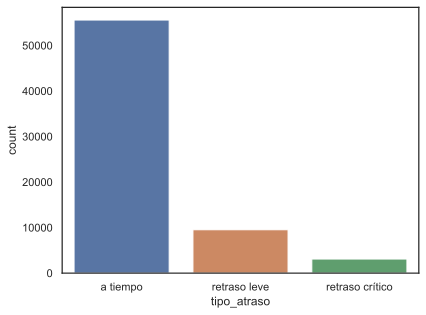

In [53]:
sns.countplot(data = df , x='tipo_atraso')

In [54]:
pd.crosstab(df['Emp-O'],df.tipo_atraso, margins=True,normalize='index')

tipo_atraso  a tiempo  retraso crítico  retraso leve
Emp-O                                               
48O          0.800000         0.100000      0.100000
56R          0.352941         0.470588      0.176471
AAL          0.932629         0.025099      0.042272
ACA          0.543363         0.175221      0.281416
AFR          0.916201         0.008380      0.075419
AMX          0.971510         0.005698      0.022792
ARG          0.760534         0.071942      0.167523
AUT          0.779221         0.038961      0.181818
AVA          0.683616         0.090395      0.225989
AZA          0.888031         0.019305      0.092664
BAW          0.858537         0.058537      0.082927
CMP          0.937297         0.009189      0.053514
DAL          0.941341         0.011173      0.047486
DSM          0.661258         0.077079      0.261663
GLO          0.643921         0.075682      0.280397
IBE          0.900552         0.016575      0.082873
JAT          0.821005         0.037443      0.141553
JMR          0.594414         0.203400      0.202186
KLM          0.916335         0.031873      0.051793
LAN          0.815323         0.039213      0.145464
LAP          0.716895         0.036530      0.246575
LNE          0.804813         0.053476      0.141711
LPE          0.768534         0.054366      0.177100
LRC          0.901961         0.016807      0.081232
LXP          0.857948         0.030705      0.111348
ONE          0.845878         0.064516      0.089606
PUE          0.387755         0.265306      0.346939
QFA          0.420513         0.179487      0.400000
SKU          0.822353         0.039656      0.137991
TAM          0.744255         0.066316      0.189429
TPU          0.000000         1.000000      0.000000
UAL          0.949254         0.014925      0.035821
All          0.815060         0.045363      0.139577

In [55]:
pd.crosstab(df.tipo_atraso,df['Emp-O'], margins=True,normalize='index')

Emp-O                 48O       56R       AAL       ACA       AFR       AMX  \
tipo_atraso                                                                   
a tiempo         0.000144  0.000108  0.012700  0.005522  0.005900  0.006134   
retraso crítico  0.000323  0.002586  0.006141  0.031997  0.000970  0.000646   
retraso leve     0.000105  0.000315  0.003361  0.016702  0.002836  0.000840   
All              0.000147  0.000249  0.011099  0.008284  0.005249  0.005146   

Emp-O                 ARG       AUT       AVA       AZA       BAW       CMP  \
tipo_atraso                                                                   
a tiempo         0.026623  0.001079  0.010883  0.004137  0.003166  0.031192   
retraso crítico  0.045249  0.000970  0.025856  0.001616  0.003878  0.005495   
retraso leve     0.034244  0.001471  0.021008  0.002521  0.001786  0.010399   
All              0.028531  0.001129  0.012975  0.003797  0.003006  0.027124   

Emp-O                 DAL       DSM       GLO       IBE       JAT       JMR  \
tipo_atraso                                                                   
a tiempo         0.006062  0.005864  0.009336  0.005864  0.016171  0.017610   
retraso crítico  0.001293  0.012282  0.019716  0.001939  0.013251  0.108274   
retraso leve     0.001786  0.013550  0.023739  0.003151  0.016282  0.034979   
All              0.005249  0.007228  0.011817  0.005307  0.016054  0.024147   

Emp-O                 KLM       LAN       LAP       LNE       LPE       LRC  \
tipo_atraso                                                                   
a tiempo         0.004137  0.307814  0.002824  0.005414  0.016783  0.005792   
retraso crítico  0.002586  0.265999  0.002586  0.006464  0.021332  0.001939   
retraso leve     0.001366  0.320693  0.005672  0.005567  0.022584  0.003046   
All              0.003680  0.307715  0.003211  0.005483  0.017799  0.005234   

Emp-O                 LXP       ONE       PUE       QFA       SKU       TAM  \
tipo_atraso                                                                   
a tiempo         0.224673  0.004245  0.000342  0.001475  0.211505  0.040779   
retraso crítico  0.144473  0.005818  0.004202  0.011312  0.183258  0.065288   
retraso leve     0.170273  0.002626  0.001786  0.008193  0.207248  0.060609   
All              0.213442  0.004091  0.000718  0.002859  0.209630  0.044659   

Emp-O                 TPU       UAL  
tipo_atraso                          
a tiempo         0.000000  0.005720  
retraso crítico  0.000646  0.001616  
retraso leve     0.000000  0.001261  
All              0.000029  0.004912

0        AAL
1        AAL
2        AAL
3        AAL
4        AAL
        ... 
68201    JAT
68202    JAT
68203    JAT
68204    JAT
68205    JAT
Name: Emp-O, Length: 68204, dtype: object

count    68204.000000
mean         0.604947
std          0.182344
min          0.000000
25%          0.480769
50%          0.625000
75%          0.740385
max          1.000000
Name: NVuelos-Ori-I, dtype: float64


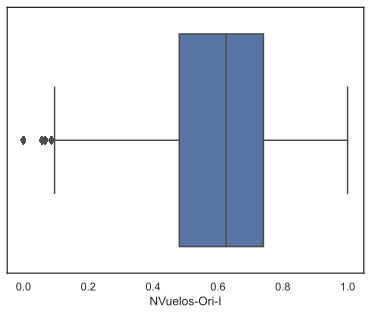

In [313]:
df = df[df['NVuelos-Ori-I']>100]
scaler = MinMaxScaler()
df.loc[:,['NVuelos-Ori-O']] = scaler.fit_transform(df[['NVuelos-Ori-O']])
scaler = MinMaxScaler()
df.loc[:,['NVuelos-Ori-I']] = scaler.fit_transform(df[['NVuelos-Ori-I']])
print(df['NVuelos-Ori-I'].describe())
sns.boxplot(data = df,x = 'NVuelos-Ori-I');

In [314]:
ibe = df[df['Emp-O'] == 'TAM']
scaler = MinMaxScaler()
ibe['NVuelos-Ori-O-Emp'] = 0
ibe.loc[:,['distance_to_destiny','NVuelos-Ori-O-Emp','Nvuelos-Fecha-Emp-O','Nvuelos-Fecha-Emp-Des-O']] = scaler.fit_transform(ibe[['distance_to_destiny','NVuelos-Ori-O',
                                                                                                         'Nvuelos-Fecha-Emp-O',
                                                                                                        'Nvuelos-Fecha-Emp-Des-O']])
ibe.corr()[['dif_min','atraso_15']]

dif_min  atraso_15
DIA                     -0.007948  -0.004379
MES                      0.021773   0.028361
AÑO                           NaN        NaN
dif_min                  1.000000   0.693975
atraso_15                0.693975   1.000000
temporada_alta           0.018712   0.009425
Lat                      0.020630   0.011438
Long                    -0.030174  -0.036021
distance_to_destiny     -0.001991  -0.015263
NVuelos-Ori-O            0.028944   0.024216
NVuelos-Ori-I            0.028944   0.024216
Nvuelos-Fecha-Emp-I      0.079682   0.070257
Nvuelos-Fecha-Emp-O      0.080973   0.070780
Nvuelos-Fecha-Emp-Des-O  0.007195  -0.010310
Nvuelos-Fecha-Emp-Des-I  0.007195  -0.010310
Vlo-I_cambio            -0.057398  -0.066368
NVuelos-Ori-O-Emp        0.028944   0.024216

In [188]:
pd.crosstab(ibe['Des-O'],ibe.tipo_atraso,normalize='index', margins=True)

tipo_atraso  a tiempo  retraso crítico  retraso leve
Des-O                                               
SAAR         0.485714         0.114286      0.400000
SBFI         1.000000         0.000000      0.000000
SBFL         1.000000         0.000000      0.000000
SBGL         0.716877         0.080442      0.202681
SBGR         0.775301         0.054217      0.170482
SPJC         0.641975         0.074074      0.283951
All          0.744255         0.066316      0.189429

In [189]:
pd.crosstab(ibe['Vlo-O'],ibe.tipo_atraso,normalize='index', margins=True)

tipo_atraso  a tiempo  retraso crítico  retraso leve
Vlo-O                                               
8021         0.795580         0.044199      0.160221
8023         0.934783         0.021739      0.043478
8027         0.828221         0.018405      0.153374
8029         0.856230         0.031949      0.111821
8069         0.693252         0.092025      0.214724
8073         0.736364         0.063636      0.200000
8075         0.822148         0.057047      0.120805
8083         0.678571         0.071429      0.250000
8099         0.714286         0.095238      0.190476
8125         0.718023         0.061047      0.220930
8131         0.470588         0.117647      0.411765
8137         0.602241         0.123249      0.274510
8160         0.610169         0.067797      0.322034
8161         0.788301         0.047354      0.164345
9461         1.000000         0.000000      0.000000
9510         0.000000         1.000000      0.000000
9540         0.000000         0.000000      1.000000
9600         0.000000         0.000000      1.000000
9601         0.500000         0.000000      0.500000
9615         0.593220         0.135593      0.271186
9622         0.000000         1.000000      0.000000
9623         0.000000         0.000000      1.000000
9629         1.000000         0.000000      0.000000
9643         0.705882         0.029412      0.264706
9651         0.760000         0.040000      0.200000
9653         0.800000         0.080000      0.120000
9659         0.322581         0.419355      0.258065
9661         0.750000         0.000000      0.250000
9662         0.000000         0.000000      1.000000
9673         0.790698         0.023256      0.186047
9689         1.000000         0.000000      0.000000
9701         1.000000         0.000000      0.000000
9782         1.000000         0.000000      0.000000
9851         1.000000         0.000000      0.000000
9955         0.000000         1.000000      0.000000
9956         1.000000         0.000000      0.000000
All          0.744255         0.066316      0.189429

In [335]:
aux = df.groupby(['Des-O']).count().sort_values(by='atraso_15').reset_index()
lista = aux[(aux.atraso_15<30)]['Des-O'].values
df['Des-O-delete'] = df['Des-O'].apply(lambda x: 1 if(x in lista) else 0)
df['Des-O-delete'].sum()

25

In [370]:
aux = df.loc[df['Des-O-delete']==0].copy()
aux = df.groupby(['Vlo-O']).count().sort_values(by='atraso_15').reset_index()
lista = aux[(aux.atraso_15<15)]['Vlo-O'].values
df['Vlo-delete'] = df['Vlo-O'].apply(lambda x: 1 if(x in lista) else 0)
df['Vlo-delete'].sum()

1754

Fecha-I Vlo-I Ori-I Des-I Emp-I              Fecha-O  \
0      2017-01-01 23:30:00   226  SCEL  KMIA   AAL  2017-01-01 23:33:00   
1      2017-01-02 23:30:00   226  SCEL  KMIA   AAL  2017-01-02 23:39:00   
2      2017-01-03 23:30:00   226  SCEL  KMIA   AAL  2017-01-03 23:39:00   
3      2017-01-04 23:30:00   226  SCEL  KMIA   AAL  2017-01-04 23:33:00   
4      2017-01-05 23:30:00   226  SCEL  KMIA   AAL  2017-01-05 23:28:00   
...                    ...   ...   ...   ...   ...                  ...   
68183  2017-12-17 16:16:00   283  SCEL  SCQP   JAT  2017-12-17 16:10:00   
68184  2017-12-22 14:20:00   283  SCEL  SCQP   JAT  2017-12-22 14:33:00   
68185  2017-12-24 16:16:00   283  SCEL  SCQP   JAT  2017-12-24 16:17:00   
68186  2017-12-29 14:20:00   283  SCEL  SCQP   JAT  2017-12-29 14:22:00   
68187  2017-12-31 16:16:00   283  SCEL  SCQP   JAT  2017-12-31 16:18:00   

       Vlo-O Ori-O Des-O Emp-O  DIA  MES   AÑO     DIANOM TIPOVUELO  \
0        226  SCEL  KMIA   AAL    1    1  2017    Domingo         I   
1        226  SCEL  KMIA   AAL    2    1  2017      Lunes         I   
2        226  SCEL  KMIA   AAL    3    1  2017     Martes         I   
3        226  SCEL  KMIA   AAL    4    1  2017  Miercoles         I   
4        226  SCEL  KMIA   AAL    5    1  2017     Jueves         I   
...      ...   ...   ...   ...  ...  ...   ...        ...       ...   
68183  283.0  SCEL  SCQP   JAT   17   12  2017    Domingo         N   
68184  283.0  SCEL  SCQP   JAT   22   12  2017    Viernes         N   
68185  283.0  SCEL  SCQP   JAT   24   12  2017    Domingo         N   
68186  283.0  SCEL  SCQP   JAT   29   12  2017    Viernes         N   
68187  283.0  SCEL  SCQP   JAT   31   12  2017    Domingo         N   

                   OPERA  SIGLAORI SIGLADES  dif_min  atraso_15 tipo_atraso  \
0      American Airlines  Santiago    Miami      3.0          0    a tiempo   
1      American Airlines  Santiago    Miami      9.0          0    a tiempo   
2      American Airlines  Santiago    Miami      9.0          0    a tiempo   
3      American Airlines  Santiago    Miami      3.0          0    a tiempo   
4      American Airlines  Santiago    Miami     -2.0          0    a tiempo   
...                  ...       ...      ...      ...        ...         ...   
68183       JetSmart SPA  Santiago   Temuco     -6.0          0    a tiempo   
68184       JetSmart SPA  Santiago   Temuco     13.0          0    a tiempo   
68185       JetSmart SPA  Santiago   Temuco      1.0          0    a tiempo   
68186       JetSmart SPA  Santiago   Temuco      2.0          0    a tiempo   
68187       JetSmart SPA  Santiago   Temuco      2.0          0    a tiempo   

      periodo_dia  temporada_alta ICAO Code IATA Code         Airport Name  \
0           night               1      KMIA       MIA  MIAMI INTERNATIONAL   
1           night               1      KMIA       MIA  MIAMI INTERNATIONAL   
2           night               1      KMIA       MIA  MIAMI INTERNATIONAL   
3           night               1      KMIA       MIA  MIAMI INTERNATIONAL   
4           night               1      KMIA       MIA  MIAMI INTERNATIONAL   
...           ...             ...       ...       ...                  ...   
68183   afternoon               1      SCQP       ZCO             MAQUEHUE   
68184   afternoon               1      SCQP       ZCO             MAQUEHUE   
68185   afternoon               1      SCQP       ZCO             MAQUEHUE   
68186   afternoon               1      SCQP       ZCO             MAQUEHUE   
68187   afternoon               1      SCQP       ZCO             MAQUEHUE   

      City/Town Country     Lat    Long  distance_to_destiny fecha_operacion  \
0         MIAMI     USA  25.793 -80.291          6627.098358        2017-1-1   
1         MIAMI     USA  25.793 -80.291          6627.098358        2017-1-2   
2         MIAMI     USA  25.793 -80.291          6627.098358        2017-1-3   
3         MIAMI     USA  25.793 -80.291          6627.09835

In [240]:
ibe[(ibe.tipo_atraso !='a tiempo')].describe()

DIA         MES     AÑO     dif_min  atraso_15  temporada_alta  \
count  779.000000  779.000000   779.0  779.000000      779.0      779.000000   
mean    15.621309    6.598203  2017.0   39.017972        1.0        0.688062   
std      8.667174    3.328856     0.0   29.251101        0.0        0.463582   
min      1.000000    1.000000  2017.0   16.000000        1.0        0.000000   
25%      8.000000    4.000000  2017.0   20.000000        1.0        0.000000   
50%     16.000000    7.000000  2017.0   27.000000        1.0        1.000000   
75%     23.000000    9.000000  2017.0   46.000000        1.0        1.000000   
max     31.000000   12.000000  2017.0  159.000000        1.0        1.000000   

              Lat        Long  distance_to_destiny  NVuelos-Ori-O  \
count  779.000000  779.000000           779.000000     779.000000   
mean   -22.938972  -46.454366             0.891252       0.608250   
std      2.619885    6.674258             0.160494       0.183031   
min    -32.903000  -77.114000             0.000000       0.067308   
25%    -23.432000  -46.469000             0.839954       0.480769   
50%    -23.432000  -46.469000             0.839954       0.634615   
75%    -22.809000  -43.244000             1.000000       0.740385   
max    -12.022000  -43.244000             1.000000       1.000000   

       NVuelos-Ori-I  Nvuelos-Fecha-Emp-I  Nvuelos-Fecha-Emp-O  \
count     779.000000           779.000000           779.000000   
mean        0.608250             8.874198             0.482991   
std         0.183031             1.730444             0.214342   
min         0.067308             5.000000             0.000000   
25%         0.480769             7.000000             0.250000   
50%         0.634615             9.000000             0.500000   
75%         0.740385            10.000000             0.625000   
max         1.000000            13.000000             1.000000   

       Nvuelos-Fecha-Emp-Des-O  Nvuelos-Fecha-Emp-Des-I  Vlo-I_cambio  \
count               779.000000               779.000000    779.000000   
mean                  0.447093                 4.129653      0.222080   
std                   0.197693                 1.383852      0.415911   
min                   0.000000                 1.000000      0.000000   
25%                   0.285714                 3.000000      0.000000   
50%                   0.428571                 4.000000      0.000000   
75%                   0.571429                 5.000000      0.000000   
max                   1.000000                 8.000000      1.000000   

       NVuelos-Ori-O-Emp  
count         779.000000  
mean            0.608250  
std             0.183031  
min             0.067308  
25%             0.480769  
50%             0.634615  
75%             0.740385  
max             1.000000

In [241]:
ibe[(ibe.tipo_atraso =='a tiempo')].describe()

DIA          MES     AÑO      dif_min  atraso_15  \
count  2267.000000  2267.000000  2267.0  2267.000000     2267.0   
mean     15.709749     6.368328  2017.0     4.507719        0.0   
std       8.864604     3.604293     0.0     5.850771        0.0   
min       1.000000     1.000000  2017.0   -14.000000        0.0   
25%       8.000000     3.000000  2017.0     0.000000        0.0   
50%      16.000000     6.000000  2017.0     5.000000        0.0   
75%      24.000000    10.000000  2017.0     9.000000        0.0   
max      31.000000    12.000000  2017.0    15.000000        0.0   

       temporada_alta          Lat         Long  distance_to_destiny  \
count     2267.000000  2267.000000  2267.000000          2267.000000   
mean         0.677989   -22.994322   -45.990600             0.895682   
std          0.467350     1.906448     5.202077             0.112723   
min          0.000000   -32.903000   -77.114000             0.000000   
25%          0.000000   -23.432000   -46.469000             0.839954   
50%          1.000000   -23.432000   -46.469000             0.839954   
75%          1.000000   -22.809000   -43.244000             1.000000   
max          1.000000   -12.022000   -43.244000             1.000000   

       NVuelos-Ori-O  NVuelos-Ori-I  Nvuelos-Fecha-Emp-I  Nvuelos-Fecha-Emp-O  \
count    2267.000000    2267.000000          2267.000000          2267.000000   
mean        0.598033       0.598033             8.598147             0.448500   
std         0.184445       0.184445             1.703653             0.211369   
min         0.000000       0.000000             5.000000             0.000000   
25%         0.480769       0.480769             7.000000             0.250000   
50%         0.625000       0.625000             8.000000             0.375000   
75%         0.740385       0.740385            10.000000             0.625000   
max         1.000000       1.000000            13.000000             1.000000   

       Nvuelos-Fecha-Emp-Des-O  Nvuelos-Fecha-Emp-Des-I  Vlo-I_cambio  \
count              2267.000000              2267.000000   2267.000000   
mean                  0.451194                 4.158359      0.289810   
std                   0.164487                 1.151412      0.453774   
min                   0.000000                 1.000000      0.000000   
25%                   0.428571                 4.000000      0.000000   
50%                   0.428571                 4.000000      0.000000   
75%                   0.571429                 5.000000      1.000000   
max                   1.000000                 8.000000      1.000000   

       NVuelos-Ori-O-Emp  
count        2267.000000  
mean            0.598033  
std             0.184445  
min             0.000000  
25%             0.480769  
50%             0.625000  
75%             0.740385  
max             1.000000

In [248]:
ibe[(ibe.tipo_atraso !='a tiempo')].groupby('MES').count()/ ibe.groupby('MES').count()

Fecha-I     Vlo-I     Ori-I     Des-I     Emp-I   Fecha-O     Vlo-O  \
MES                                                                         
1    0.222930  0.222930  0.222930  0.222930  0.222930  0.222930  0.222930   
2    0.244147  0.244147  0.244147  0.244147  0.244147  0.244147  0.244147   
3    0.138249  0.138249  0.138249  0.138249  0.138249  0.138249  0.138249   
4    0.195122  0.195122  0.195122  0.195122  0.195122  0.195122  0.195122   
5    0.259259  0.259259  0.259259  0.259259  0.259259  0.259259  0.259259   
6    0.264151  0.264151  0.264151  0.264151  0.264151  0.264151  0.264151   
7    0.455927  0.455927  0.455927  0.455927  0.455927  0.455927  0.455927   
8    0.333333  0.333333  0.333333  0.333333  0.333333  0.333333  0.333333   
9    0.181070  0.181070  0.181070  0.181070  0.181070  0.181070  0.181070   
10   0.217778  0.217778  0.217778  0.217778  0.217778  0.217778  0.217778   
11   0.200000  0.200000  0.200000  0.200000  0.200000  0.200000  0.200000   
12   0.266917  0.266917  0.266917  0.266917  0.266917  0.266917  0.266917   

        Ori-O     Des-O     Emp-O       DIA       AÑO    DIANOM  TIPOVUELO  \
MES                                                                          
1    0.222930  0.222930  0.222930  0.222930  0.222930  0.222930   0.222930   
2    0.244147  0.244147  0.244147  0.244147  0.244147  0.244147   0.244147   
3    0.138249  0.138249  0.138249  0.138249  0.138249  0.138249   0.138249   
4    0.195122  0.195122  0.195122  0.195122  0.195122  0.195122   0.195122   
5    0.259259  0.259259  0.259259  0.259259  0.259259  0.259259   0.259259   
6    0.264151  0.264151  0.264151  0.264151  0.264151  0.264151   0.264151   
7    0.455927  0.455927  0.455927  0.455927  0.455927  0.455927   0.455927   
8    0.333333  0.333333  0.333333  0.333333  0.333333  0.333333   0.333333   
9    0.181070  0.181070  0.181070  0.181070  0.181070  0.181070   0.181070   
10   0.217778  0.217778  0.217778  0.217778  0.217778  0.217778   0.217778   
11   0.200000  0.200000  0.200000  0.200000  0.200000  0.200000   0.200000   
12   0.266917  0.266917  0.266917  0.266917  0.266917  0.266917   0.266917   

        OPERA  SIGLAORI  SIGLADES   dif_min  atraso_15  tipo_atraso  \
MES                                                                   
1    0.222930  0.222930  0.222930  0.222930   0.222930     0.222930   
2    0.244147  0.244147  0.244147  0.244147   0.244147     0.244147   
3    0.138249  0.138249  0.138249  0.138249   0.138249     0.138249   
4    0.195122  0.195122  0.195122  0.195122   0.195122     0.195122   
5    0.259259  0.259259  0.259259  0.259259   0.259259     0.259259   
6    0.264151  0.264151  0.264151  0.264151   0.264151     0.264151   
7    0.455927  0.455927  0.455927  0.455927   0.455927     0.455927   
8    0.333333  0.333333  0.333333  0.333333   0.333333     0.333333   
9    0.181070  0.181070  0.181070  0.181070   0.181070     0.181070   
10   0.217778  0.217778  0.217778  0.217778   0.217778     0.217778   
11   0.200000  0.200000  0.200000  0.200000   0.200000     0.200000   
12   0.266917  0.266917  0.266917  0.266917   0.266917     0.266917   

     periodo_dia  temporada_alta  ICAO Code  IATA Code  Airport Name  \
MES                                                                    
1       0.222930        0.222930   0.222930   0.222930      0.222930   
2       0.244147        0.244147   0.244147   0.244147      0.244147   
3       0.138249        0.138249   0.138249   0.138249      0.138249   
4       0.195122        0.195122   0.195122   0.195122      0.195122   
5       0.259259        0.259259   0.259259   0.259259      0.259259   
6       0.264151        0.264151   0.264151   0.264151      0.264151   
7       0.455927        0.455927   0.455927   0.455927      0.455927   
8       0.333333        0.333333   0.333333   0.333333      0.333333   
9       0.181070        0.181070   0.181070   0.181070      0.181070   
10      0.217778        0.217778   0.217778   0

In [235]:
ibe[(ibe['Des-O']=='SBGL') & (ibe.tipo_atraso !='a tiempo')].groupby('DIANOM').count()/ ibe[(ibe['Des-O']=='SBGL')].groupby('DIANOM').count()

Fecha-I     Vlo-I     Ori-I     Des-I     Emp-I   Fecha-O  \
DIANOM                                                                  
Domingo    0.289773  0.289773  0.289773  0.289773  0.289773  0.289773   
Jueves     0.291892  0.291892  0.291892  0.291892  0.291892  0.291892   
Lunes      0.234694  0.234694  0.234694  0.234694  0.234694  0.234694   
Martes     0.252688  0.252688  0.252688  0.252688  0.252688  0.252688   
Miercoles  0.256684  0.256684  0.256684  0.256684  0.256684  0.256684   
Sabado     0.304094  0.304094  0.304094  0.304094  0.304094  0.304094   
Viernes    0.365269  0.365269  0.365269  0.365269  0.365269  0.365269   

              Vlo-O     Ori-O     Des-O     Emp-O       DIA       MES  \
DIANOM                                                                  
Domingo    0.289773  0.289773  0.289773  0.289773  0.289773  0.289773   
Jueves     0.291892  0.291892  0.291892  0.291892  0.291892  0.291892   
Lunes      0.234694  0.234694  0.234694  0.234694  0.234694  0.234694   
Martes     0.252688  0.252688  0.252688  0.252688  0.252688  0.252688   
Miercoles  0.256684  0.256684  0.256684  0.256684  0.256684  0.256684   
Sabado     0.304094  0.304094  0.304094  0.304094  0.304094  0.304094   
Viernes    0.365269  0.365269  0.365269  0.365269  0.365269  0.365269   

                AÑO  TIPOVUELO     OPERA  SIGLAORI  SIGLADES   dif_min  \
DIANOM                                                                   
Domingo    0.289773   0.289773  0.289773  0.289773  0.289773  0.289773   
Jueves     0.291892   0.291892  0.291892  0.291892  0.291892  0.291892   
Lunes      0.234694   0.234694  0.234694  0.234694  0.234694  0.234694   
Martes     0.252688   0.252688  0.252688  0.252688  0.252688  0.252688   
Miercoles  0.256684   0.256684  0.256684  0.256684  0.256684  0.256684   
Sabado     0.304094   0.304094  0.304094  0.304094  0.304094  0.304094   
Viernes    0.365269   0.365269  0.365269  0.365269  0.365269  0.365269   

           atraso_15  tipo_atraso  periodo_dia  temporada_alta  ICAO Code  \
DIANOM                                                                      
Domingo     0.289773     0.289773     0.289773        0.289773   0.289773   
Jueves      0.291892     0.291892     0.291892        0.291892   0.291892   
Lunes       0.234694     0.234694     0.234694        0.234694   0.234694   
Martes      0.252688     0.252688     0.252688        0.252688   0.252688   
Miercoles   0.256684     0.256684     0.256684        0.256684   0.256684   
Sabado      0.304094     0.304094     0.304094        0.304094   0.304094   
Viernes     0.365269     0.365269     0.365269        0.365269   0.365269   

           IATA Code  Airport Name  City/Town   Country       Lat      Long  \
DIANOM                                                                        
Domingo     0.289773      0.289773   0.289773  0.289773  0.289773  0.289773   
Jueves      0.291892      0.291892   0.291892  0.291892  0.291892  0.291892   
Lunes       0.234694      0.234694   0.234694  0.234694  0.234694  0.234694   
Martes      0.252688      0.252688   0.252688  0.252688  0.252688  0.252688   
Miercoles   0.256684      0.256684   0.256684  0.256684  0.256684  0.256684   
Sabado      0.304094      0.304094   0.304094  0.304094  0.304094  0.304094   
Viernes     0.365269      0.365269   0.365269  0.365269  0.365269  0.365269   

           distance_to_destiny  fecha_operacion  NVuelos-Ori-O  NVuelos-Ori-I  \
DIANOM                                                                          
Domingo               0.289773         0.289773       0.289773       0.289773   
Jueves                0.291892         0.291892       0.291892       0.291892   
Lunes                 0.234694         0.234694       0.234694       0.234694   
Martes                0.252688         0.252688       0.252688       0.252688   
Miercoles             0.256684         0.256684       0.256684       0.256684   
Sabado                0.304094         0.304094       0.

In [218]:
ibe[(ibe['Des-O']=='SBGL') & (ibe.tipo_atraso !='a tiempo')].groupby('MES').count()/ ibe[(ibe['Des-O']=='SBGL')].groupby('MES').count()

Fecha-I     Vlo-I     Ori-I     Des-I     Emp-I   Fecha-O     Vlo-O  \
MES                                                                         
1    0.233333  0.233333  0.233333  0.233333  0.233333  0.233333  0.233333   
2    0.188525  0.188525  0.188525  0.188525  0.188525  0.188525  0.188525   
3    0.193548  0.193548  0.193548  0.193548  0.193548  0.193548  0.193548   
4    0.247191  0.247191  0.247191  0.247191  0.247191  0.247191  0.247191   
5    0.265957  0.265957  0.265957  0.265957  0.265957  0.265957  0.265957   
6    0.333333  0.333333  0.333333  0.333333  0.333333  0.333333  0.333333   
7    0.575000  0.575000  0.575000  0.575000  0.575000  0.575000  0.575000   
8    0.416667  0.416667  0.416667  0.416667  0.416667  0.416667  0.416667   
9    0.238095  0.238095  0.238095  0.238095  0.238095  0.238095  0.238095   
10   0.281818  0.281818  0.281818  0.281818  0.281818  0.281818  0.281818   
11   0.169811  0.169811  0.169811  0.169811  0.169811  0.169811  0.169811   
12   0.222222  0.222222  0.222222  0.222222  0.222222  0.222222  0.222222   

        Ori-O     Des-O     Emp-O       DIA       AÑO    DIANOM  TIPOVUELO  \
MES                                                                          
1    0.233333  0.233333  0.233333  0.233333  0.233333  0.233333   0.233333   
2    0.188525  0.188525  0.188525  0.188525  0.188525  0.188525   0.188525   
3    0.193548  0.193548  0.193548  0.193548  0.193548  0.193548   0.193548   
4    0.247191  0.247191  0.247191  0.247191  0.247191  0.247191   0.247191   
5    0.265957  0.265957  0.265957  0.265957  0.265957  0.265957   0.265957   
6    0.333333  0.333333  0.333333  0.333333  0.333333  0.333333   0.333333   
7    0.575000  0.575000  0.575000  0.575000  0.575000  0.575000   0.575000   
8    0.416667  0.416667  0.416667  0.416667  0.416667  0.416667   0.416667   
9    0.238095  0.238095  0.238095  0.238095  0.238095  0.238095   0.238095   
10   0.281818  0.281818  0.281818  0.281818  0.281818  0.281818   0.281818   
11   0.169811  0.169811  0.169811  0.169811  0.169811  0.169811   0.169811   
12   0.222222  0.222222  0.222222  0.222222  0.222222  0.222222   0.222222   

        OPERA  SIGLAORI  SIGLADES   dif_min  atraso_15  tipo_atraso  \
MES                                                                   
1    0.233333  0.233333  0.233333  0.233333   0.233333     0.233333   
2    0.188525  0.188525  0.188525  0.188525   0.188525     0.188525   
3    0.193548  0.193548  0.193548  0.193548   0.193548     0.193548   
4    0.247191  0.247191  0.247191  0.247191   0.247191     0.247191   
5    0.265957  0.265957  0.265957  0.265957   0.265957     0.265957   
6    0.333333  0.333333  0.333333  0.333333   0.333333     0.333333   
7    0.575000  0.575000  0.575000  0.575000   0.575000     0.575000   
8    0.416667  0.416667  0.416667  0.416667   0.416667     0.416667   
9    0.238095  0.238095  0.238095  0.238095   0.238095     0.238095   
10   0.281818  0.281818  0.281818  0.281818   0.281818     0.281818   
11   0.169811  0.169811  0.169811  0.169811   0.169811     0.169811   
12   0.222222  0.222222  0.222222  0.222222   0.222222     0.222222   

     periodo_dia  temporada_alta  ICAO Code  IATA Code  Airport Name  \
MES                                                                    
1       0.233333        0.233333   0.233333   0.233333      0.233333   
2       0.188525        0.188525   0.188525   0.188525      0.188525   
3       0.193548        0.193548   0.193548   0.193548      0.193548   
4       0.247191        0.247191   0.247191   0.247191      0.247191   
5       0.265957        0.265957   0.265957   0.265957      0.265957   
6       0.333333        0.333333   0.333333   0.333333      0.333333   
7       0.575000        0.575000   0.575000   0.575000      0.575000   
8       0.416667        0.416667   0.416667   0.416667      0.416667   
9       0.238095        0.238095   0.238095   0.238095      0.238095   
10      0.281818        0.281818   0.281818   0

In [250]:
ibe[(ibe['Des-O']=='SBGL') & (ibe.tipo_atraso =='a tiempo') & (ibe.MES==7)].describe()

DIA   MES     AÑO    dif_min  atraso_15  temporada_alta  \
count  51.000000  51.0    51.0  51.000000       51.0       51.000000   
mean   14.941176   7.0  2017.0   6.235294        0.0        0.470588   
std     9.729156   0.0     0.0   5.327619        0.0        0.504101   
min     1.000000   7.0  2017.0  -4.000000        0.0        0.000000   
25%     6.500000   7.0  2017.0   2.000000        0.0        0.000000   
50%    13.000000   7.0  2017.0   7.000000        0.0        0.000000   
75%    23.500000   7.0  2017.0  10.500000        0.0        1.000000   
max    31.000000   7.0  2017.0  15.000000        0.0        1.000000   

                Lat          Long  distance_to_destiny  NVuelos-Ori-O  \
count  5.100000e+01  5.100000e+01                 51.0      51.000000   
mean  -2.280900e+01 -4.324400e+01                  1.0       0.642911   
std    1.076419e-14  2.152839e-14                  0.0       0.149135   
min   -2.280900e+01 -4.324400e+01                  1.0       0.269231   
25%   -2.280900e+01 -4.324400e+01                  1.0       0.605769   
50%   -2.280900e+01 -4.324400e+01                  1.0       0.682692   
75%   -2.280900e+01 -4.324400e+01                  1.0       0.730769   
max   -2.280900e+01 -4.324400e+01                  1.0       0.846154   

       NVuelos-Ori-I  Nvuelos-Fecha-Emp-I  Nvuelos-Fecha-Emp-O  \
count      51.000000            51.000000            51.000000   
mean        0.642911            10.666667             0.708333   
std         0.149135             0.553775             0.069222   
min         0.269231             9.000000             0.500000   
25%         0.605769            10.000000             0.625000   
50%         0.682692            11.000000             0.750000   
75%         0.730769            11.000000             0.750000   
max         0.846154            12.000000             0.875000   

       Nvuelos-Fecha-Emp-Des-O  Nvuelos-Fecha-Emp-Des-I  Vlo-I_cambio  \
count                51.000000                51.000000          51.0   
mean                  0.411765                 3.882353           0.0   
std                   0.046485                 0.325396           0.0   
min                   0.285714                 3.000000           0.0   
25%                   0.428571                 4.000000           0.0   
50%                   0.428571                 4.000000           0.0   
75%                   0.428571                 4.000000           0.0   
max                   0.428571                 4.000000           0.0   

       NVuelos-Ori-O-Emp  
count          51.000000  
mean            0.642911  
std             0.149135  
min             0.269231  
25%             0.605769  
50%             0.682692  
75%             0.730769  
max             0.846154

In [230]:
ibe[(ibe['Des-O']=='SBGL') & (ibe.tipo_atraso != 'a tiempo')& (ibe.MES==1)].sort_values(by='DIA').describe()

DIA   MES     AÑO    dif_min  atraso_15  temporada_alta  \
count  28.000000  28.0    28.0  28.000000       28.0            28.0   
mean   14.392857   1.0  2017.0  26.571429        1.0             1.0   
std     8.786940   0.0     0.0  14.970164        0.0             0.0   
min     1.000000   1.0  2017.0  16.000000        1.0             1.0   
25%     7.000000   1.0  2017.0  18.000000        1.0             1.0   
50%    15.500000   1.0  2017.0  19.000000        1.0             1.0   
75%    21.000000   1.0  2017.0  29.000000        1.0             1.0   
max    30.000000   1.0  2017.0  75.000000        1.0             1.0   

                Lat          Long  distance_to_destiny  NVuelos-Ori-O  \
count  2.800000e+01  2.800000e+01                 28.0      28.000000   
mean  -2.280900e+01 -4.324400e+01                  1.0       0.671360   
std    3.617907e-15  7.235813e-15                  0.0       0.107648   
min   -2.280900e+01 -4.324400e+01                  1.0       0.403846   
25%   -2.280900e+01 -4.324400e+01                  1.0       0.596154   
50%   -2.280900e+01 -4.324400e+01                  1.0       0.701923   
75%   -2.280900e+01 -4.324400e+01                  1.0       0.754808   
max   -2.280900e+01 -4.324400e+01                  1.0       0.798077   

       NVuelos-Ori-I  Nvuelos-Fecha-Emp-I  Nvuelos-Fecha-Emp-O  \
count      28.000000            28.000000            28.000000   
mean        0.671360            10.464286             0.669643   
std         0.107648             1.373887             0.160346   
min         0.403846             8.000000             0.375000   
25%         0.596154             9.000000             0.500000   
50%         0.701923            10.500000             0.687500   
75%         0.754808            12.000000             0.781250   
max         0.798077            12.000000             0.875000   

       Nvuelos-Fecha-Emp-Des-O  Nvuelos-Fecha-Emp-Des-I  Vlo-I_cambio  \
count                28.000000                28.000000          28.0   
mean                  0.438776                 4.071429           1.0   
std                   0.102343                 0.716399           0.0   
min                   0.285714                 3.000000           1.0   
25%                   0.428571                 4.000000           1.0   
50%                   0.428571                 4.000000           1.0   
75%                   0.571429                 5.000000           1.0   
max                   0.571429                 5.000000           1.0   

       NVuelos-Ori-O-Emp  
count          28.000000  
mean            0.671360  
std             0.107648  
min             0.403846  
25%             0.596154  
50%             0.701923  
75%             0.754808  
max             0.798077

In [181]:
ibe = df[df['Emp-O'] == 'IBE']
scaler = MinMaxScaler()
ibe['NVuelos-Ori-O-Emp'] = 0
ibe.loc[:,['distance_to_destiny','NVuelos-Ori-O-Emp','Nvuelos-Fecha-Emp-O','Nvuelos-Fecha-Emp-Des-O']] = scaler.fit_transform(ibe[['distance_to_destiny','NVuelos-Ori-O',
                                                                                                         'Nvuelos-Fecha-Emp-O',
                                                                                                        'Nvuelos-Fecha-Emp-Des-O']])
ibe.corr()[['dif_min','atraso_15']]

dif_min  atraso_15
DIA                      0.012543   0.037412
MES                     -0.060766  -0.040332
AÑO                           NaN        NaN
dif_min                  1.000000   0.706627
atraso_15                0.706627   1.000000
temporada_alta           0.015654   0.038949
Lat                           NaN        NaN
Long                          NaN        NaN
distance_to_destiny           NaN        NaN
NVuelos-Ori-O            0.104604   0.062775
NVuelos-Ori-I            0.104604   0.062775
Nvuelos-Fecha-Emp-I           NaN        NaN
Nvuelos-Fecha-Emp-O           NaN        NaN
Nvuelos-Fecha-Emp-Des-O       NaN        NaN
Nvuelos-Fecha-Emp-Des-I       NaN        NaN
Vlo-I_cambio             0.074308   0.046073
NVuelos-Ori-O-Emp        0.104604   0.062775

In [143]:
pd.crosstab(ibe['Des-O'],ibe.tipo_atraso,normalize='index', margins=True)

tipo_atraso  a tiempo  retraso crítico  retraso leve
Des-O                                               
LEMD         0.900552         0.016575      0.082873
All          0.900552         0.016575      0.082873

In [142]:
pd.crosstab(ibe['Vlo-O'],ibe.tipo_atraso,normalize='index', margins=True)

tipo_atraso  a tiempo  retraso crítico  retraso leve
Vlo-O                                               
6830         0.900552         0.016575      0.082873
All          0.900552         0.016575      0.082873

In [183]:
ibe[(ibe['Vlo-O']=='6830') & (ibe.MES==1)]

Fecha-I Vlo-I Ori-I Des-I Emp-I              Fecha-O Vlo-O  \
762  2017-01-01 13:40:00  6830  SCEL  LEMD   IBE  2017-01-01 13:49:00  6830   
763  2017-01-02 13:40:00  6830  SCEL  LEMD   IBE  2017-01-02 13:38:00  6830   
764  2017-01-03 13:40:00  6830  SCEL  LEMD   IBE  2017-01-03 13:44:00  6830   
765  2017-01-04 13:40:00  6830  SCEL  LEMD   IBE  2017-01-04 13:55:00  6830   
766  2017-01-05 13:40:00  6830  SCEL  LEMD   IBE  2017-01-05 13:41:00  6830   
767  2017-01-06 13:40:00  6830  SCEL  LEMD   IBE  2017-01-06 13:42:00  6830   
768  2017-01-07 13:40:00  6830  SCEL  LEMD   IBE  2017-01-07 13:47:00  6830   
769  2017-01-08 13:40:00  6830  SCEL  LEMD   IBE  2017-01-08 13:29:00  6830   
770  2017-01-09 13:40:00  6830  SCEL  LEMD   IBE  2017-01-09 13:55:00  6830   
771  2017-01-10 13:40:00  6830  SCEL  LEMD   IBE  2017-01-10 13:40:00  6830   
772  2017-01-11 13:40:00  6830  SCEL  LEMD   IBE  2017-01-11 13:42:00  6830   
773  2017-01-12 13:40:00  6830  SCEL  LEMD   IBE  2017-01-12 13:44:00  6830   
774  2017-01-13 13:40:00  6830  SCEL  LEMD   IBE  2017-01-13 13:43:00  6830   
775  2017-01-14 13:40:00  6830  SCEL  LEMD   IBE  2017-01-14 13:59:00  6830   
776  2017-01-15 13:40:00  6830  SCEL  LEMD   IBE  2017-01-15 14:19:00  6830   
777  2017-01-16 13:40:00  6830  SCEL  LEMD   IBE  2017-01-16 13:43:00  6830   
778  2017-01-17 13:40:00  6830  SCEL  LEMD   IBE  2017-01-17 13:52:00  6830   
779  2017-01-18 13:40:00  6830  SCEL  LEMD   IBE  2017-01-18 13:57:00  6830   
780  2017-01-19 13:40:00  6830  SCEL  LEMD   IBE  2017-01-19 14:45:00  6830   
781  2017-01-20 13:40:00  6830  SCEL  LEMD   IBE  2017-01-20 13:44:00  6830   
782  2017-01-21 13:40:00  6830  SCEL  LEMD   IBE  2017-01-21 13:46:00  6830   
783  2017-01-22 13:40:00  6830  SCEL  LEMD   IBE  2017-01-22 13:49:00  6830   
784  2017-01-23 13:40:00  6830  SCEL  LEMD   IBE  2017-01-23 13:46:00  6830   
785  2017-01-24 13:40:00  6830  SCEL  LEMD   IBE  2017-01-24 14:07:00  6830   
786  2017-01-25 13:40:00  6830  SCEL  LEMD   IBE  2017-01-25 13:42:00  6830   
787  2017-01-26 13:40:00  6830  SCEL  LEMD   IBE  2017-01-26 13:43:00  6830   
788  2017-01-27 13:40:00  6830  SCEL  LEMD   IBE  2017-01-27 13:33:00  6830   
789  2017-01-28 13:40:00  6830  SCEL  LEMD   IBE  2017-01-28 13:37:00  6830   
790  2017-01-29 13:40:00  6830  SCEL  LEMD   IBE  2017-01-29 13:44:00  6830   
791  2017-01-30 13:40:00  6830  SCEL  LEMD   IBE  2017-01-30 13:55:00  6830   
792  2017-01-31 13:40:00  6830  SCEL  LEMD   IBE  2017-01-31 13:39:00  6830   

    Ori-O Des-O Emp-O  DIA  MES   AÑO     DIANOM TIPOVUELO   OPERA  SIGLAORI  \
762  SCEL  LEMD   IBE    1    1  2017    Domingo         I  Iberia  Santiago   
763  SCEL  LEMD   IBE    2    1  2017      Lunes         I  Iberia  Santiago   
764  SCEL  LEMD   IBE    3    1  2017     Martes         I  Iberia  Santiago   
765  SCEL  LEMD   IBE    4    1  2017  Miercoles         I  Iberia  Santiago   
766  SCEL  LEMD   IBE    5    1  2017     Jueves         I  Iberia  Santiago   
767  SCEL  LEMD   IBE    6    1  2017    Viernes         I  Iberia  Santiago   
768  SCEL  LEMD   IBE    7    1  2017     Sabado         I  Iberia  Santiago   
769  SCEL  LEMD   IBE    8    1  2017    Domingo         I  Iberia  Santiago   
770  SCEL  LEMD   IBE    9    1  2017      Lunes         I  Iberia  Santiago   
771  SCEL  LEMD   IBE   10    1  2017     Martes         I  Iberia  Santiago   
772  SCEL  LEMD   IBE   11    1  2017  Miercoles         I  Iberia  Santiago   
773  SCEL  LEMD   IBE   12    1  2017     Jueves         I  Iberia  Santiago   
774  SCEL  LEMD   IBE   13    1  2017    Viernes         I  Iberia  Santiago   
775  SCEL  LEMD   IBE   14    1  2017     Sabado         I  Iberia  Santiago   
776  SCEL  LEMD   IBE   15    1  2017    Domingo         I  Iberia  Santiago   
777  SCEL  LEMD   IBE   16    1  2017      Lunes         I  Iberia  Santiago   
778  SCEL  LEMD   IBE   17    1  2017     Martes         I  Iberia  Santiago   
779  SCEL  LEMD   IBE   18    1  2017  Miercoles

In [182]:
ibe[(ibe['Vlo-O']=='6830') & (ibe.tipo_atraso !='a tiempo')]

Fecha-I Vlo-I Ori-I Des-I Emp-I              Fecha-O Vlo-O  \
775    2017-01-14 13:40:00  6830  SCEL  LEMD   IBE  2017-01-14 13:59:00  6830   
776    2017-01-15 13:40:00  6830  SCEL  LEMD   IBE  2017-01-15 14:19:00  6830   
779    2017-01-18 13:40:00  6830  SCEL  LEMD   IBE  2017-01-18 13:57:00  6830   
780    2017-01-19 13:40:00  6830  SCEL  LEMD   IBE  2017-01-19 14:45:00  6830   
785    2017-01-24 13:40:00  6830  SCEL  LEMD   IBE  2017-01-24 14:07:00  6830   
6769   2017-02-08 13:40:00  6830  SCEL  LEMD   IBE  2017-02-08 13:59:00  6830   
6770   2017-02-09 13:40:00  6830  SCEL  LEMD   IBE  2017-02-09 14:11:00  6830   
6782   2017-02-21 13:40:00  6830  SCEL  LEMD   IBE  2017-02-21 13:56:00  6830   
12334  2017-03-01 13:40:00  6830  SCEL  LEMD   IBE  2017-03-01 14:01:00  6830   
12356  2017-03-24 13:40:00  6830  SCEL  LEMD   IBE  2017-03-24 13:58:00  6830   
12359  2017-03-27 12:40:00  6830  SCEL  LEMD   IBE  2017-03-27 13:02:00  6830   
17823  2017-04-04 12:40:00  6830  SCEL  LEMD   IBE  2017-04-04 12:59:00  6830   
17829  2017-04-10 12:40:00  6830  SCEL  LEMD   IBE  2017-04-10 13:09:00  6830   
17844  2017-04-25 12:40:00  6830  SCEL  LEMD   IBE  2017-04-25 12:57:00  6830   
22875  2017-05-13 12:40:00  6830  SCEL  LEMD   IBE  2017-05-13 13:10:00  6830   
22882  2017-05-20 11:40:00  6830  SCEL  LEMD   IBE  2017-05-20 12:30:00  6830   
22887  2017-05-25 11:40:00  6830  SCEL  LEMD   IBE  2017-05-25 12:15:00  6830   
28091  2017-06-05 11:40:00  6830  SCEL  LEMD   IBE  2017-06-05 13:47:00  6830   
28114  2017-06-29 11:25:00  6830  SCEL  LEMD   IBE  2017-06-29 12:25:00  6830   
33196  2017-07-10 11:25:00  6830  SCEL  LEMD   IBE  2017-07-10 11:47:00  6830   
33201  2017-07-15 11:25:00  6830  SCEL  LEMD   IBE  2017-07-15 12:00:00  6830   
33202  2017-07-16 11:25:00  6830  SCEL  LEMD   IBE  2017-07-16 11:41:00  6830   
33203  2017-07-17 11:25:00  6830  SCEL  LEMD   IBE  2017-07-17 11:48:00  6830   
33204  2017-07-18 11:25:00  6830  SCEL  LEMD   IBE  2017-07-18 11:42:00  6830   
33217  2017-07-31 11:25:00  6830  SCEL  LEMD   IBE  2017-07-31 11:59:00  6830   
39148  2017-08-17 12:25:00  6830  SCEL  LEMD   IBE  2017-08-17 12:48:00  6830   
39152  2017-08-21 12:25:00  6830  SCEL  LEMD   IBE  2017-08-21 12:43:00  6830   
50412  2017-10-05 12:25:00  6830  SCEL  LEMD   IBE  2017-10-05 12:41:00  6830   
56455  2017-11-15 13:35:00  6830  SCEL  LEMD   IBE  2017-11-15 14:02:00  6830   
56462  2017-11-22 13:35:00  6830  SCEL  LEMD   IBE  2017-11-22 14:25:00  6830   
56465  2017-11-25 13:35:00  6830  SCEL  LEMD   IBE  2017-11-25 13:53:00  6830   
62555  2017-12-01 13:35:00  6830  SCEL  LEMD   IBE  2017-12-01 14:01:00  6830   
62564  2017-12-10 13:35:00  6830  SCEL  LEMD   IBE  2017-12-10 13:56:00  6830   
62575  2017-12-21 13:35:00  6830  SCEL  LEMD   IBE  2017-12-21 13:59:00  6830   
62576  2017-12-22 13:35:00  6830  SCEL  LEMD   IBE  2017-12-22 13:55:00  6830   
62577  2017-12-23 13:35:00  6830  SCEL  LEMD   IBE  2017-12-23 14:39:00  6830   

      Ori-O Des-O Emp-O  DIA  MES   AÑO     DIANOM TIPOVUELO   OPERA  \
775    SCEL  LEMD   IBE   14    1  2017     Sabado         I  Iberia   
776    SCEL  LEMD   IBE   15    1  2017    Domingo         I  Iberia   
779    SCEL  LEMD   IBE   18    1  2017  Miercoles         I  Iberia   
780    SCEL  LEMD   IBE   19    1  2017     Jueves         I  Iberia   
785    SCEL  LEMD   IBE   24    1  2017     Martes         I  Iberia   
6769   SCEL  LEMD   IBE    8    2  2017  Miercoles         I  Iberia   
6770   SCEL  LEMD   IBE    9    2  2017     Jueves         I  Iberia   
6782   SCEL  LEMD   IBE   21    2  2017     Martes         I  Iberia   
12334  SCEL  LEMD   IBE    1    3  2017  Miercoles         I  Iberia   
12356  SCEL  LEMD   IBE   24    3  2017    Viernes         I  Iberia   
12359  SCEL  LEMD   IBE   27    3  2017      Lunes         I  Iberia   
17823  SCEL  LEMD   IBE    4    4  2017     Martes         I  Iberia   
17829  SCEL  LEMD   IBE   10    4  2017      Lunes         I  Iberia   
17844  SCEL  

count    50023.000000
mean         9.698479
std         19.968612
min        -14.000000
25%         -1.000000
50%          4.000000
75%         12.000000
max        161.000000
Name: dif_min, dtype: float64


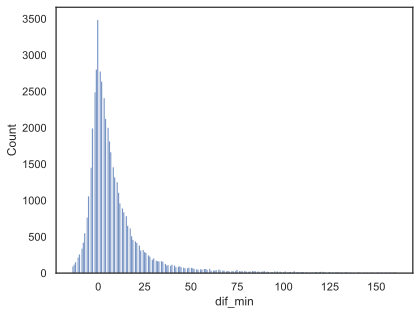

In [9]:
print(df[df['Vlo-I'] == df['Vlo-O']].dif_min.describe())
sns.histplot(df[df['Vlo-I'] == df['Vlo-O']].dif_min);

count    18183.000000
mean         7.494253
std         17.281564
min        -14.000000
25%         -1.000000
50%          3.000000
75%         10.000000
max        161.000000
Name: dif_min, dtype: float64


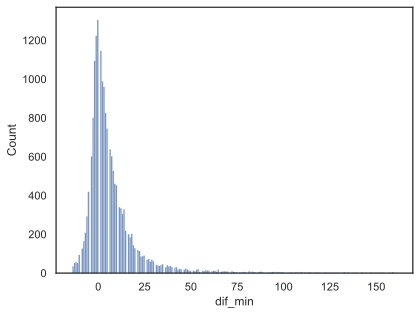

In [10]:
print(df[df['Vlo-I'] != df['Vlo-O']].dif_min.describe())
sns.histplot(df[df['Vlo-I'] != df['Vlo-O']].dif_min);

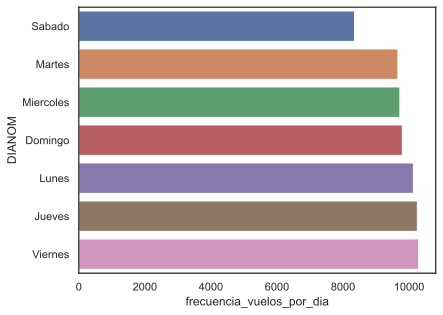

In [11]:
aux = df.groupby(['DIANOM'])['Ori-O'].count().reset_index().sort_values(by='Ori-O')
aux.rename(columns={'Ori-O':'frecuencia_vuelos_por_dia'}, inplace=True)
sns.barplot(data=aux, y= "DIANOM",x= "frecuencia_vuelos_por_dia", orient="h");

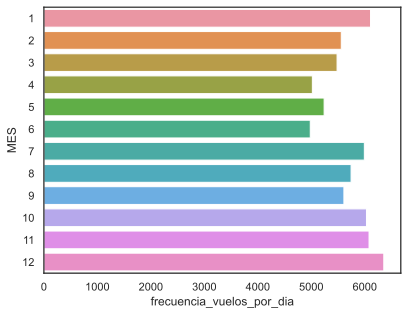

In [12]:
aux = df.groupby(['MES'])['Ori-O'].count().reset_index().sort_values(by='Ori-O')
aux.rename(columns={'Ori-O':'frecuencia_vuelos_por_dia'}, inplace=True)
sns.barplot(data=aux, y= "MES",x= "frecuencia_vuelos_por_dia", orient="h");

In [13]:
aux

MES  frecuencia_vuelos_por_dia
5     6                       4981
3     4                       5020
4     5                       5240
2     3                       5482
1     2                       5561
8     9                       5610
7     8                       5744
6     7                       5992
9    10                       6032
10   11                       6080
0     1                       6108
11   12                       6356

In [14]:
tab = pd.crosstab(df.periodo_dia,df.atraso_15, margins=True)
tab.index = ["afternoon","morning","night",'row_total']
tab.columns = ["Sin atraso","Con atraso",'col_total']
observed = tab.iloc[0:3,0:2]   # Get table without totals for later use
chi2 = scipy.stats.chi2_contingency(observed= observed)
if(chi2[1]<0.01):
    print("rechazamos H0")
else: 
    print("no hay evidencia para rechazar H0")

rechazamos H0


In [15]:
df.groupby('periodo_dia')['dif_min'].describe()

count      mean        std   min  25%  50%   75%    max
periodo_dia                                                           
afternoon    25506.0  9.757155  18.857409 -14.0  0.0  4.0  13.0  161.0
morning      25352.0  8.061534  18.186330 -14.0 -1.0  3.0  10.0  161.0
night        17348.0  9.694086  21.397243 -14.0 -1.0  3.0  12.0  161.0

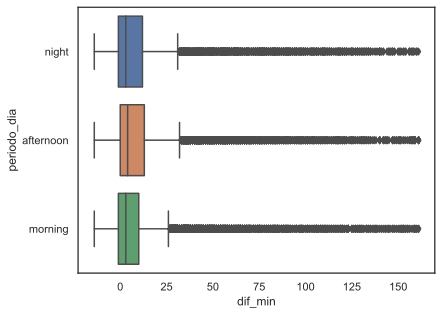

In [16]:
sns.boxplot(data=df, x= "dif_min",y= "periodo_dia", orient="h");

In [17]:
df.groupby(["atraso_15",'periodo_dia'])['dif_min'].describe()

count       mean        std   min   25%   50%   75%  \
atraso_15 periodo_dia                                                          
0         afternoon    20420.0   2.915867   5.654592 -14.0  -1.0   2.0   7.0   
          morning      21294.0   2.430685   5.666680 -14.0  -1.0   2.0   6.0   
          night        13878.0   1.785344   6.331795 -14.0  -2.0   1.0   6.0   
1         afternoon     5086.0  37.224538  26.695595  16.0  20.0  27.0  43.0   
          morning       4058.0  37.608921  29.300128  16.0  19.0  26.0  43.0   
          night         3470.0  41.324496  29.632683  16.0  21.0  30.0  50.0   

                         max  
atraso_15 periodo_dia         
0         afternoon     15.0  
          morning       15.0  
          night         15.0  
1         afternoon    161.0  
          morning      161.0  
          night        161.0

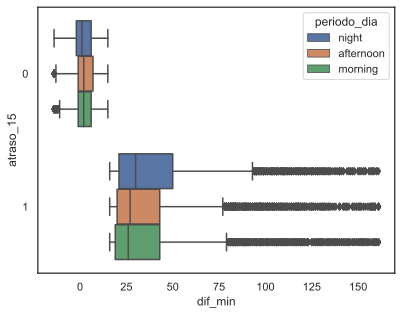

In [18]:
sns.boxplot(data=df, x= "dif_min",y= "atraso_15", hue='periodo_dia',orient="h");

In [19]:
pd.crosstab(df.periodo_dia,df.atraso_15, margins=True,normalize='index')

atraso_15           0         1
periodo_dia                    
afternoon    0.800596  0.199404
morning      0.839934  0.160066
night        0.799977  0.200023
All          0.815060  0.184940

In [20]:
pd.crosstab(df.atraso_15,df.periodo_dia, margins=True,normalize='index')

periodo_dia  afternoon   morning     night
atraso_15                                 
0             0.367319  0.383041  0.249640
1             0.403203  0.321706  0.275091
All           0.373955  0.371698  0.254347

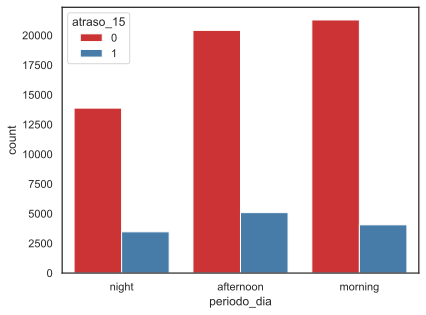

In [21]:
sns.countplot(hue='atraso_15', x='periodo_dia', data=df, palette='Set1');

In [22]:
df.groupby(['TIPOVUELO'])['dif_min'].describe()

count       mean        std   min  25%  50%   75%    max
TIPOVUELO                                                            
I          31240.0  10.638892  21.579424 -14.0 -1.0  5.0  14.0  161.0
N          36966.0   7.819510  17.060643 -14.0 -1.0  3.0  10.0  161.0

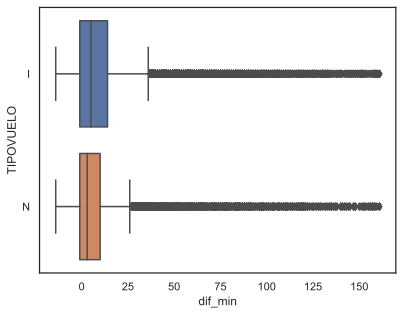

In [23]:
sns.boxplot(data=df, x= "dif_min",y= 'TIPOVUELO',orient="h");

In [24]:
df.groupby(["atraso_15",'TIPOVUELO'])['dif_min'].describe()

count       mean        std   min   25%   50%   75%  \
atraso_15 TIPOVUELO                                                          
0         I          24192.0   2.247065   6.614241 -14.0  -2.0   2.0   7.0   
          N          31400.0   2.602452   5.183085 -14.0  -1.0   2.0   6.0   
1         I           7048.0  39.443530  29.026486  16.0  20.0  28.0  47.0   
          N           5566.0  37.250988  27.601816  16.0  19.0  26.0  43.0   

                       max  
atraso_15 TIPOVUELO         
0         I           15.0  
          N           15.0  
1         I          161.0  
          N          161.0

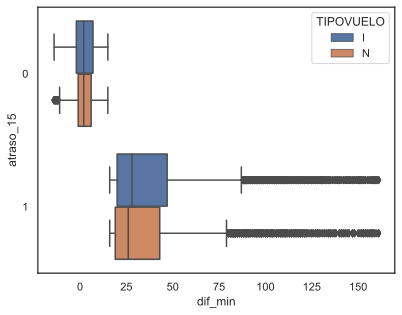

In [25]:
sns.boxplot(data=df, x= "dif_min",y= "atraso_15", hue='TIPOVUELO',orient="h");

In [26]:
pd.crosstab(df.TIPOVUELO,df.atraso_15, margins=True,normalize='index')

atraso_15         0         1
TIPOVUELO                    
I          0.774392  0.225608
N          0.849429  0.150571
All        0.815060  0.184940

In [27]:
pd.crosstab(df.atraso_15,df.TIPOVUELO, margins=True,normalize='index')

TIPOVUELO         I         N
atraso_15                    
0          0.435171  0.564829
1          0.558744  0.441256
All        0.458024  0.541976

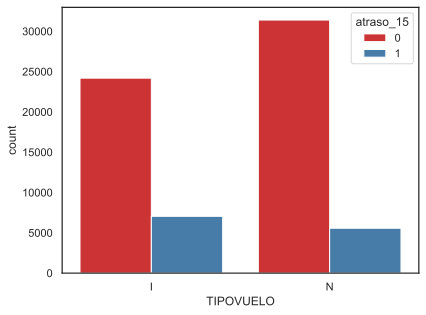

In [28]:
sns.countplot(hue='atraso_15',x='TIPOVUELO', data=df, palette='Set1');

In [29]:
df.groupby(['MES'])['dif_min'].describe()

count       mean        std   min  25%  50%   75%    max
MES                                                           
1    6108.0   7.769646  16.710173 -14.0 -1.0  3.0  11.0  161.0
2    5561.0   7.537853  17.504430 -14.0 -1.0  3.0  10.0  160.0
3    5482.0   5.757205  16.781073 -14.0 -2.0  2.0   8.0  161.0
4    5020.0   5.773506  15.123701 -14.0 -1.0  2.0   8.0  161.0
5    5240.0   7.521756  16.920480 -14.0 -1.0  3.0  10.0  161.0
6    4981.0   8.542461  19.439951 -14.0 -1.0  3.0  11.0  161.0
7    5992.0  15.372163  25.457811 -14.0  1.0  7.0  18.0  161.0
8    5744.0   8.616818  19.041656 -14.0 -1.0  3.0  11.0  161.0
9    5610.0   8.497326  19.048354 -14.0 -1.0  3.0  11.0  159.0
10   6032.0  11.295922  21.559598 -14.0  0.0  5.0  14.0  160.0
11   6080.0   9.342763  18.409677 -14.0  0.0  4.0  13.0  161.0
12   6356.0  11.849591  20.314042 -14.0  0.0  6.0  16.0  159.0

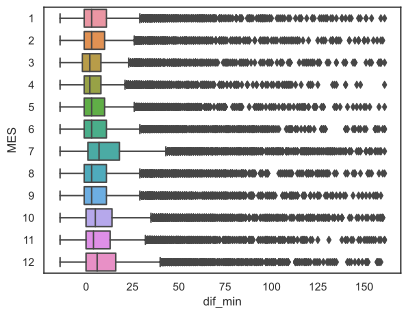

In [30]:
sns.boxplot(data=df, x= "dif_min",y= 'MES',orient="h");

In [31]:
pd.crosstab(df.MES,df.atraso_15, margins=True,normalize='index')

atraso_15         0         1
MES                          
1          0.839882  0.160118
2          0.848409  0.151591
3          0.884896  0.115104
4          0.883466  0.116534
5          0.842176  0.157824
6          0.828950  0.171050
7          0.706609  0.293391
8          0.826602  0.173398
9          0.827629  0.172371
10         0.774038  0.225962
11         0.802796  0.197204
12         0.745909  0.254091
All        0.815060  0.184940

In [32]:
pd.crosstab(df.atraso_15,df.MES, margins=True,normalize='index')

MES               1         2         3         4         5         6  \
atraso_15                                                               
0          0.092279  0.084868  0.087261  0.079778  0.079382  0.074273   
1          0.077533  0.066831  0.050024  0.046377  0.065562  0.067544   
All        0.089552  0.081532  0.080374  0.073601  0.076826  0.073029   

MES               7         8         9        10        11        12  
atraso_15                                                              
0          0.076162  0.085408  0.083519  0.083987  0.087800  0.085282  
1          0.139369  0.078960  0.076661  0.108055  0.095053  0.128032  
All        0.087852  0.084215  0.082251  0.088438  0.089142  0.093188

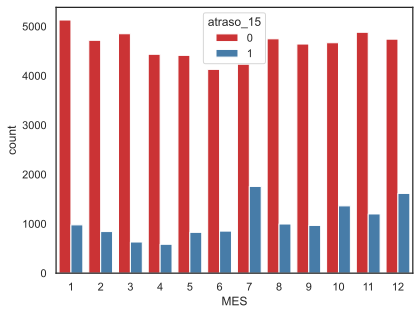

In [33]:
sns.countplot(hue='atraso_15',x='MES', data=df, palette='Set1');

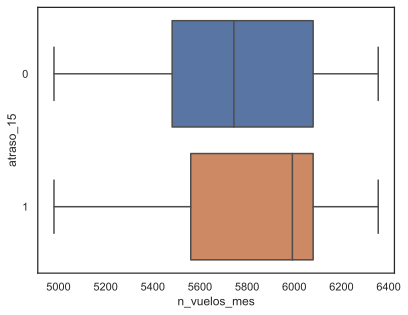

In [34]:
aux = df.groupby(['MES'])['Ori-O'].count().reset_index().sort_values(by='Ori-O')
aux.rename(columns={'Ori-O':'n_vuelos_mes'}, inplace=True)
df = pd.merge(df, aux, on = ['MES'], how='left')
sns.boxplot(data=df, x= "n_vuelos_mes",y= "atraso_15", orient="h");

                  mean       50%       75%  n_vuelos_mes
mean          1.000000  0.976594  0.983246      0.616735
50%           0.976594  1.000000  0.986379      0.679645
75%           0.983246  0.986379  1.000000      0.708048
n_vuelos_mes  0.616735  0.679645  0.708048      1.000000


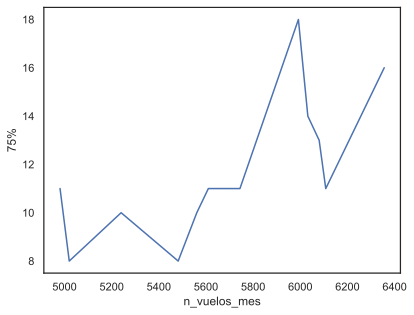

In [35]:
aux = df.groupby(['n_vuelos_mes'])['dif_min'].describe().reset_index()
print(aux[['mean','50%','75%','n_vuelos_mes']].corr())
sns.lineplot(data=aux, x='n_vuelos_mes', y='75%');

                  mean  n_vuelos_mes
mean          1.000000      0.681131
n_vuelos_mes  0.681131      1.000000


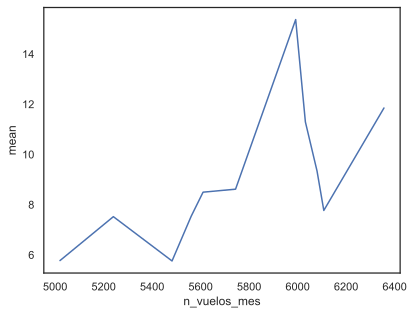

In [36]:
aux = df.groupby(['n_vuelos_mes'])['dif_min'].describe().reset_index()[1:]
print(aux[['mean','n_vuelos_mes']].corr())
sns.lineplot(data=aux, x='n_vuelos_mes', y='mean');

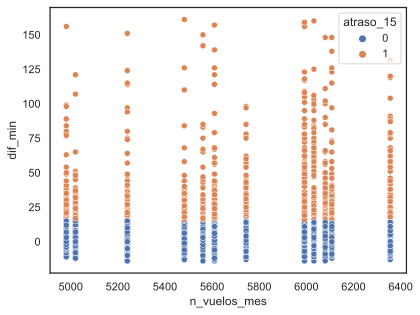

In [37]:
sns.scatterplot(data=df.sample(5000), x='n_vuelos_mes', y='dif_min', hue='atraso_15');

In [116]:
aal = df[df['Emp-O'] == 'AAL']
scaler = MinMaxScaler()
aal['NVuelos-Ori-O-Emp'] = 0
aal.loc[:,['distance_to_destiny','NVuelos-Ori-O-Emp','Nvuelos-Fecha-Emp-O','Nvuelos-Fecha-Emp-Des-O']] = scaler.fit_transform(aal[['distance_to_destiny','NVuelos-Ori-O',
                                                                                                         'Nvuelos-Fecha-Emp-O',
                                                                                                        'Nvuelos-Fecha-Emp-Des-O']])
aal.corr()[['dif_min','atraso_15']]

dif_min  atraso_15
DIA                      0.019738   0.015392
MES                     -0.060988  -0.037742
AÑO                           NaN        NaN
dif_min                  1.000000   0.767298
atraso_15                0.767298   1.000000
temporada_alta           0.009716   0.035098
Lat                     -0.067327   0.013458
Long                     0.077790  -0.010944
distance_to_destiny     -0.074875   0.012374
NVuelos-Ori-O            0.018166   0.032959
NVuelos-Ori-I            0.018166   0.032959
Nvuelos-Fecha-Emp-I      0.097220   0.052947
Nvuelos-Fecha-Emp-O      0.097220   0.052947
Nvuelos-Fecha-Emp-Des-O  0.130588   0.068003
Nvuelos-Fecha-Emp-Des-I  0.130588   0.068003
Vlo-I_cambio             0.031875   0.016897
NVuelos-Ori-O-Emp        0.018166   0.032959

In [117]:
pd.crosstab(aal.tipo_atraso,aal['Des-O'], margins=True,normalize='index')

Des-O                KDFW      KMIA      SUMU
tipo_atraso                                  
a tiempo         0.470255  0.528329  0.001416
retraso crítico  0.315789  0.684211  0.000000
retraso leve     0.593750  0.406250  0.000000
All              0.471598  0.527081  0.001321

In [118]:
pd.crosstab(aal['Des-O'],aal.tipo_atraso,normalize='index', margins=True)

tipo_atraso  a tiempo  retraso crítico  retraso leve
Des-O                                               
KDFW         0.929972         0.016807      0.053221
KMIA         0.934837         0.032581      0.032581
SUMU         1.000000         0.000000      0.000000
All          0.932629         0.025099      0.042272

In [119]:
pd.crosstab(aal['Vlo-O'],aal.tipo_atraso,normalize='index', margins=True)

tipo_atraso  a tiempo  retraso crítico  retraso leve
Vlo-O                                               
226          0.903846         0.057692      0.038462
912          0.939306         0.028902      0.031792
940          0.929972         0.016807      0.053221
9625         1.000000         0.000000      0.000000
989          1.000000         0.000000      0.000000
All          0.932629         0.025099      0.042272

In [120]:
pd.crosstab(aal['SIGLADES'],aal.tipo_atraso,normalize='index', margins=True)

tipo_atraso  a tiempo  retraso crítico  retraso leve
SIGLADES                                            
Dallas       0.929972         0.016807      0.053221
Miami        0.934837         0.032581      0.032581
Montevideo   1.000000         0.000000      0.000000
All          0.932629         0.025099      0.042272

In [121]:
aal[(aal['Vlo-I']==226) & (aal.tipo_atraso !='a tiempo')]

Fecha-I Vlo-I Ori-I Des-I Emp-I              Fecha-O Vlo-O  \
5     2017-01-06 23:30:00   226  SCEL  KMIA   AAL  2017-01-07 00:04:00   226   
8     2017-01-09 23:30:00   226  SCEL  KMIA   AAL  2017-01-10 00:10:00   226   
9     2017-01-11 23:30:00   226  SCEL  KMIA   AAL  2017-01-12 00:39:00   226   
6116  2017-02-25 23:30:00   226  SCEL  KMIA   AAL  2017-02-26 00:49:00   226   

     Ori-O Des-O Emp-O  DIA  MES   AÑO   DIANOM TIPOVUELO              OPERA  \
5     SCEL  KMIA   AAL    7    1  2017   Sabado         I  American Airlines   
8     SCEL  KMIA   AAL   10    1  2017   Martes         I  American Airlines   
9     SCEL  KMIA   AAL   12    1  2017   Jueves         I  American Airlines   
6116  SCEL  KMIA   AAL   26    2  2017  Domingo         I  American Airlines   

      SIGLAORI SIGLADES  dif_min  atraso_15      tipo_atraso periodo_dia  \
5     Santiago    Miami     34.0          1     retraso leve       night   
8     Santiago    Miami     40.0          1     retraso leve       night   
9     Santiago    Miami     69.0          1  retraso crítico       night   
6116  Santiago    Miami     79.0          1  retraso crítico       night   

      temporada_alta ICAO Code IATA Code         Airport Name City/Town  \
5                  1      KMIA       MIA  MIAMI INTERNATIONAL     MIAMI   
8                  1      KMIA       MIA  MIAMI INTERNATIONAL     MIAMI   
9                  1      KMIA       MIA  MIAMI INTERNATIONAL     MIAMI   
6116               1      KMIA       MIA  MIAMI INTERNATIONAL     MIAMI   

     Country     Lat    Long  distance_to_destiny fecha_operacion  \
5        USA  25.793 -80.291             0.813023        2017-1-7   
8        USA  25.793 -80.291             0.813023       2017-1-10   
9        USA  25.793 -80.291             0.813023       2017-1-12   
6116     USA  25.793 -80.291             0.813023       2017-2-26   

      NVuelos-Ori-O  NVuelos-Ori-I  Nvuelos-Fecha-Emp-I  Nvuelos-Fecha-Emp-O  \
5          0.763158            176                    4             1.000000   
8          0.850877            196                    3             0.666667   
9          0.855263            197                    3             0.666667   
6116       0.842105            194                    2             0.333333   

      Nvuelos-Fecha-Emp-Des-O  Nvuelos-Fecha-Emp-Des-I  Vlo-I_cambio  \
5                         1.0                        3             1   
8                         0.5                        2             1   
9                         0.5                        2             1   
6116                      0.0                        1             1   

      NVuelos-Ori-O-Emp  
5              0.480769  
8              0.673077  
9              0.682692  
6116           0.653846

In [137]:
aal[(aal['Vlo-I']==226) & (aal.MES ==1) & (aal.DIA == 6)]

Empty DataFrame
Columns: [Fecha-I, Vlo-I, Ori-I, Des-I, Emp-I, Fecha-O, Vlo-O, Ori-O, Des-O, Emp-O, DIA, MES, AÑO, DIANOM, TIPOVUELO, OPERA, SIGLAORI, SIGLADES, dif_min, atraso_15, tipo_atraso, periodo_dia, temporada_alta, ICAO Code, IATA Code, Airport Name, City/Town, Country, Lat, Long, distance_to_destiny, fecha_operacion, NVuelos-Ori-O, NVuelos-Ori-I, Nvuelos-Fecha-Emp-I, Nvuelos-Fecha-Emp-O, Nvuelos-Fecha-Emp-Des-O, Nvuelos-Fecha-Emp-Des-I, Vlo-I_cambio, NVuelos-Ori-O-Emp]
Index: []

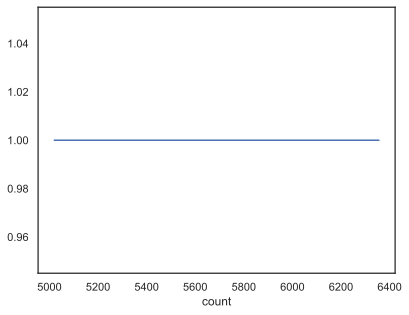

In [44]:
sns.lineplot(data=aux, x='count', y= 1);

In [45]:
aux.corr()

n_vuelos_mes     count      mean       std  min       25%  \
n_vuelos_mes      1.000000  1.000000  0.681131  0.585446  NaN  0.599948   
count             1.000000  1.000000  0.681131  0.585446  NaN  0.599948   
mean              0.681131  0.681131  1.000000  0.961993  NaN  0.925872   
std               0.585446  0.585446  0.961993  1.000000  NaN  0.830051   
min                    NaN       NaN       NaN       NaN  NaN       NaN   
25%               0.599948  0.599948  0.925872  0.830051  NaN  1.000000   
50%               0.711808  0.711808  0.979865  0.907073  NaN  0.923611   
75%               0.772584  0.772584  0.983526  0.907610  NaN  0.929114   
max              -0.310571 -0.310571 -0.228605 -0.211177  NaN -0.123299   

                   50%       75%       max  
n_vuelos_mes  0.711808  0.772584 -0.310571  
count         0.711808  0.772584 -0.310571  
mean          0.979865  0.983526 -0.228605  
std           0.907073  0.907610 -0.211177  
min                NaN       NaN       NaN  
25%           0.923611  0.929114 -0.123299  
50%           1.000000  0.987851 -0.273998  
75%           0.987851  1.000000 -0.273888  
max          -0.273998 -0.273888  1.000000